In [1]:
import numpy as np
import cv2 as cv
import matplotlib.path as mpltPath
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from haversine import inverse_haversine, Unit
import pickle

%matplotlib notebook


In [2]:
# cameraH maps from rectified to unrectified pixel coordinates
cameraH = np.array([[ 1.03570118e+00,  2.20209220e-01, -6.56401026e+01],
 [-2.47759214e-01,  9.72997542e-01,  7.11706249e+01],
 [ 1.01353307e-04, -5.38746250e-05,  1.00000000e+00]])

R_left_abs = np.array([[ 0.9904186, -0.04264348, -0.13134906], 
 [ 0.13727167, 0.40789312 , 0.90265155],
 [ 0.01508419, -0.9120333, 0.40983865]])


### Create masks

In [3]:
#note: different resolutions have different coordinate systems...

#timestamp location for 1280x960
mask_points_time1 = np.array([[587, 19.3],
                             [587, 32.7],
                             [690.3, 32.7],
                             [690.3, 19.3]])

#timestamp location for 640x480
mask_points_time3 = np.array([[266, 33],
                             [266, 19],
                             [373, 19],
                             [373, 33],
                             [272, 33]])

#mask for buildings for camera 1, 1280x960 --> need to divde coordinates by 2 to get the 640x480 coordinates
img1_mask = np.array([[  2.78 , 869.98],
                             [ 3.40, 863.84],
                             [ 5.93, 863.07],
                             [ 6.7, 855.32],
                             [ 7.77,854.01],
                             [ 16.60, 853.17],
                             [ 41.55, 815.55],
                             [ 54.83, 805.65],
                             [ 56.14, 822.31],
                             [ 58.44, 840.66],
                             [ 64.28, 881.04],
                             [ 67.65, 881.81],
                             [ 73.18, 875.2],
                             [ 75.1 , 889.17],
                             [ 79.55 , 890.94],
                             [ 81.01, 894.47],
                             [90.38, 895.24],
                             [ 91.76, 907.29],
                             [96.44, 907.52 ],
                             [102.28, 899.62],
                             [110.18, 881.34],
                             [111.8, 882.8 ],
                             [115.17, 906.45],
                             [167.92, 906.68],
                             [179.92, 907.29],
                             [181.43, 902.61],
                             [185.03, 904.38],
                             [185.11, 910.36],
                             [191.64, 910.44 ],
                             [206.61, 889.41],
                             [214.74, 889.94],
                             [231.8, 908.2],
                             [246.5, 906.2],
                             [317.7, 906.4],
                             [319 , 879.3],
                             [328.9, 879.3],
                             [331.5 , 875.2],
                             [339.2 , 873.9],
                             [342.0, 862.4],
                             [355.6, 882.3],
                             [354.1, 912.3],
                             [376.4, 911.9 ],
                             [379.2, 902],
                             [392.1, 903.7],
                             [392.1, 909.2],
                             [415.2, 910.3],
                             [415.9, 918.7],
                             [469.2, 917.4],
                             [470.5, 912.1],
                             [476.5, 911.6],
                             [482.8, 779],
                             [893.2, 779],
                             [910.0, 938.5],
                             [1022.9, 939.0],
                             [1025.2, 952.8],
                             [1055.4, 952.8],
                             [1052.9, 929.3],
                             [1054.8, 929.3],
                             [1059.3, 956.1],
                             [1093.7, 955.9],
                             [1112.1, 957.8],
                             [1119.1, 941.2],
                             [1119.8, 916.2],
                             [1123.8, 916.8],
                             [1143.7, 956.9],
                             [1156.7, 958.2],
                             [1093.3, 624.8],
                             [1130.8, 551.1],
                             [1125.0, 518.1],
                             [1128.2, 478.4],
                             [1154.5, 526],
                             [1161.8, 551.1],
                             [1202.9, 587.3],
                             [1225.0, 593.7],
                             [1276.8, 801.0]])

#use this for the low res image (640x480) (i think)
img1_mask_lowres = img1_mask/2

#mask for buildings for camera 3 
img3_mask = np.array([[  0.0001 , 431.9],
                             [ 7.78, 397.65],
                             [ 15.16, 399.28],
                             [ 6.05, 445.8],
                             [ 27.63,448.1],
                             [ 28.01, 452.52],
                             [ 33.39, 452.99],
                             [ 34.73, 450.11],
                             [ 69.93, 451.65],
                             [ 71.18, 458.27],
                             [ 75.78, 457.31],
                             [ 76.74, 453.53],
                             [ 83.93, 453.47],
                             [ 84.32 , 457.12],
                             [ 89.11 , 457.6],
                             [ 90.07, 452.71],
                             [97.94, 453.09],
                             [ 98.23, 457.02],
                             [101.49, 456.45 ],
                             [101.49, 451.17],
                             [112.23, 452.62],
                             [114.92, 466.04 ],
                             [124.32, 449.93],
                             [124.70, 459.91],
                             [153.76, 459.52],
                             [154.82, 450.02],
                             [155.39, 451.46],
                             [162.2, 462.97],
                             [174.58, 436.5 ],
                             [176.88, 424.79],
                             [186.18, 424.41],
                             [190.21, 452.52],
                             [192.42, 434.29],
                             [196.25, 434.67],
                             [197.12 ,426.71],
                             [214.86, 427.29],
                             [215.63 , 451.17],
                             [220.23 , 439.28],
                             [226.66, 439.37],
                             [230.88, 460.38],
                             [240.66, 460.19],
                             [243.16, 454.53 ],
                             [251.89, 454.15],
                             [256.87, 446.57],
                             [263.97, 454.43],
                             [264.64, 462.68],
                             [268.1, 462.97],
                             [269.44, 456.45],
                             [278.65, 462.78],
                             [278.84, 459.33],
                             [281.24, 457.85],
                             [296.88, 457.6],
                             [296.1, 462.78],
                             [311.07, 463.55],
                             [313.27, 459.9],
                             [341.67, 460.57],
                             [342.34, 447.82],
                             [346.56, 447.91],
                             [346.37, 462.3],
                             [369.0, 460.76],
                             [368.81, 455.1],
                             [375.62, 455.01],
                             [375.81, 462.30],
                             [395.09, 462.11],
                             [395.0, 449],
                             [399.6, 449.35],
                             [399.5, 460.8],
                             [413.03, 462.3],
                             [412.16, 445.61],
                             [416.0, 444.07],
                             [415.04, 426.91],
                             [425.21, 426.04],
                             [427.13, 432.95],
                             [425.21, 426.04],
                             [427.13, 432.37],
                             [430.96, 426.04],
                             [433.46, 432.37],
                             [439.12,431.99],
                             [438.45, 399.95],
                             [443.05, 400.72],
                             [444.58, 430.93],
                             [555.56, 434.1],
                             [556.62, 437.94],
                             [567.74, 437.07],
                             [580.02, 430.26],
                             [599.88,429.40],
                             [604.19, 437.17],
                             [612.44, 437.46],
                             [613.3, 430.74],
                             [612.46, 432.76],
                             [622.03, 438.42],
                             [628.84, 438.61],
                             [636.04, 470.84],
                             [639.3, 470.55]])


def gen_mask(points, imshape, timemask=None):
    # make blank mask
    ind_y, ind_x = np.meshgrid(np.arange(0.5, imshape[1]),
                               np.arange(0.5, imshape[0]))
    # Ensure the points go to the edge of the image
    newpoints = [[641, points[-1, 1]],
                 [641, -1],
                 [-1, -1],
                 [-1, points[0, 1]],
                 [points[0, 0], points[0, 1]]]
    points = np.concatenate((points, newpoints), axis=0)
    points_poly = mpltPath.Path(points)
    mask = points_poly.contains_points(np.array(list(zip(ind_x.ravel(), ind_y.ravel())))).reshape(imshape)

    if timemask is not None:
        points_poly = mpltPath.Path(timemask)
        tmask = points_poly.contains_points(np.array(list(zip(ind_x.ravel(), ind_y.ravel())))).reshape(imshape)
        mask = mask & ~tmask
        
    return mask.transpose()[:, :, None].astype('uint8')

mask_C1 = gen_mask(img1_mask_lowres, (640, 480), timemask=mask_points_time1/2)
mask_C3 = gen_mask(img3_mask, (640, 480), timemask=mask_points_time3)

### Load extrinsic parameters for cameras

In [4]:
%cd "C:\Users\kathe\OneDrive\Documents\GitHub\cloud-stereo-new"
stereo_cal = pickle.load( open( 'stereo_cal_mat.pkl', "rb" ) )

C:\Users\kathe\OneDrive\Documents\GitHub\cloud-stereo-new


### Create a raster image containing star positions for left and right camera to check zero error in rectification

<IPython.core.display.Javascript object>


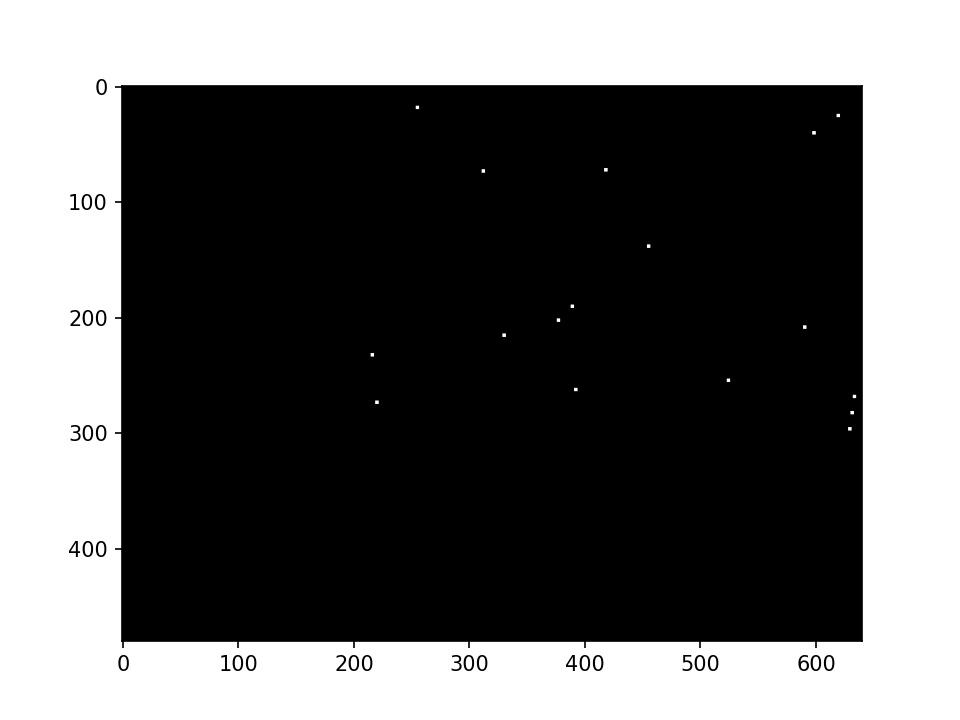

<IPython.core.display.Javascript object>


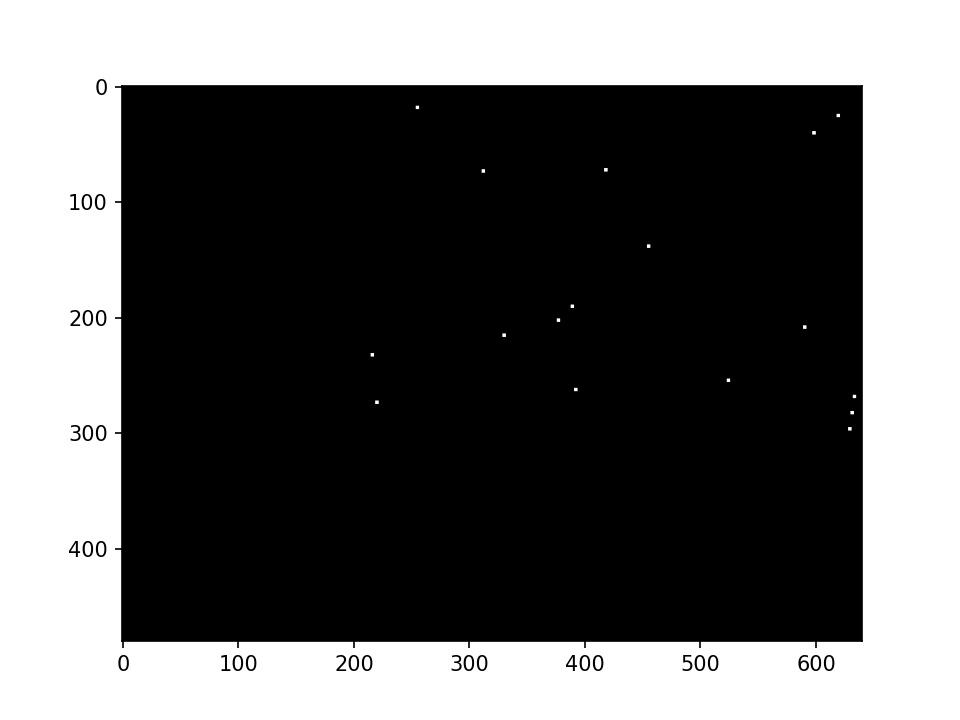

In [5]:
starsL = np.array([(632.8054393305439, 267.8347280334728),
 (631.4665271966527, 281.89330543933056),
 (628.7887029288703, 295.95188284518827),
 (589.9602510460251, 208.2531380753138),
 (524.3535564853556, 254.4456066945607),
 (597.9937238493724, 40.219665271966505),
 (618.7468619246862, 25.4916317991632),
 (454.73012552301253, 137.96025104602512),
 (417.91004184100416, 71.68410041841008),
 (391.8012552301255, 262.47907949790795),
 (389.1234309623431, 189.50836820083686),
 (377.07322175732213, 201.55857740585776),
 (330.2112970711297, 214.94769874476987),
 (312.1359832635983, 73.02301255230128),
 (254.56276150627613, 18.127615062761492),
 (219.75104602510459, 272.52092050209205),
 (215.73430962343096, 232.35355648535568),
 (330.2112970711297, 214.94769874476987)])

starsR = np.array([(638.1610878661088, 278.5460251046025),
 (637.4916317991632, 292.60460251046027),
 (634.8138075313807, 306.663179916318),
 (592.6380753138075, 217.62552301255232),
 (527.7008368200836, 265.826359832636),
 (593.9769874476988, 50.26150627615061),
 (614.0606694560669, 36.87238493723851),
 (452.72175732217573, 149.34100418410043),
 (414.56276150627616, 85.07322175732219),
 (393.14016736401675, 275.1987447698745),
 (388.4539748953975, 202.89748953974896),
 (375.73430962343093, 214.27824267782427),
 (330.2112970711297, 227.66736401673643),
 (308.7887029288703, 87.75104602510464),
 (251.8849372384937, 35.53347280334731),
 (218.4121338912134, 287.2489539748954),
 (214.39539748953973, 247.081589958159),
 (329.5418410041841, 226.99790794979083)])

blank_imageL = np.zeros((480, 640, 3)).astype(np.uint8)
for pos in starsL:
    blank_imageL[int(np.round(pos[1])), int(np.round(pos[0]))] = [255,255,255]
    blank_imageL[int(np.round(pos[1]))+1, int(np.round(pos[0]))+1] = [255,255,255]
    blank_imageL[int(np.round(pos[1]))-1, int(np.round(pos[0]))-1] = [255,255,255]
    blank_imageL[int(np.round(pos[1]))+1, int(np.round(pos[0]))-1] = [255,255,255]
    blank_imageL[int(np.round(pos[1]))-1, int(np.round(pos[0]))+1] = [255,255,255]
    blank_imageL[int(np.round(pos[1])), int(np.round(pos[0]))+1] = [255,255,255]
    blank_imageL[int(np.round(pos[1])), int(np.round(pos[0]))-1] = [255,255,255]
    blank_imageL[int(np.round(pos[1]))+1, int(np.round(pos[0]))] = [255,255,255]
    blank_imageL[int(np.round(pos[1]))-1, int(np.round(pos[0]))] = [255,255,255]

plt.imshow(blank_imageL)

blank_imageR = np.zeros((480, 640, 3)).astype(np.uint8)
for pos in starsR:
    blank_imageR[int(np.round(pos[1])), int(np.round(pos[0]))] = [255,255,255]
    blank_imageR[int(np.round(pos[1]))+1, int(np.round(pos[0]))+1] = [255,255,255]
    blank_imageR[int(np.round(pos[1]))-1, int(np.round(pos[0]))-1] = [255,255,255]
    blank_imageR[int(np.round(pos[1]))+1, int(np.round(pos[0]))-1] = [255,255,255]
    blank_imageR[int(np.round(pos[1]))-1, int(np.round(pos[0]))+1] = [255,255,255]
    blank_imageR[int(np.round(pos[1])), int(np.round(pos[0]))+1] = [255,255,255]
    blank_imageR[int(np.round(pos[1])), int(np.round(pos[0]))-1] = [255,255,255]
    blank_imageR[int(np.round(pos[1]))+1, int(np.round(pos[0]))] = [255,255,255]
    blank_imageR[int(np.round(pos[1]))-1, int(np.round(pos[0]))] = [255,255,255]

fig, ax = plt.subplots(1,1)
ax.imshow(blank_imageL)

### Undistort and rectify the images so that corresponding points are on epipolar lines

In [6]:
#camera matrices and distortion for the 640x480 resolution
#i am using the 640x480v2 values for both cameras because camera3 doesn't have its own
CamM_left = np.array([[5.520688775958645920e+02,0.000000000000000000e+00,3.225866125962970159e+02],
          [0.000000000000000000e+00,5.502640890663026312e+02,2.362389385357402034e+02],
          [0.000000000000000000e+00,0.000000000000000000e+00,1.000000000000000000e+00]])

CamM_right = np.array([[5.520688775958645920e+02,0.000000000000000000e+00,3.225866125962970159e+02],
          [0.000000000000000000e+00,5.502640890663026312e+02,2.362389385357402034e+02],
          [0.000000000000000000e+00,0.000000000000000000e+00,1.000000000000000000e+00]])

# camera matrices with the intrinsics that Ronnie was using
# CamM_left = np.array([[5.084752337001038995e+02,0.000000000000000000e+00, 3.225185456035997049e+02],
#                              [0.000000000000000000e+00,5.111127135158413921e+02,2.505901000840876520e+02],
#                              [0.000000000000000000e+00,0.000000000000000000e+00,1.000000000000000000e+00]])
# CamM_right = np.array([[5.084752337001038995e+02,0.000000000000000000e+00, 3.225185456035997049e+02],
#                              [0.000000000000000000e+00,5.111127135158413921e+02,2.505901000840876520e+02],
#                              [0.000000000000000000e+00,0.000000000000000000e+00,1.000000000000000000e+00]])

Distort_left = np.array([2.808374038768443048e-01,-9.909134707088265159e-01,6.299531255281858727e-04,-1.301770463801651002e-03,1.093982545460403522e+00])
Distort_right = np.array([2.808374038768443048e-01,-9.909134707088265159e-01,6.299531255281858727e-04,-1.301770463801651002e-03,1.093982545460403522e+00])
# Distort_left = np.array([2.557079871649052816e-01,-6.904984023652400715e-01,1.200890653459153572e-03,1.726519391474843354e-03,6.352641343146406827e-01])
# Distort_right = np.array([2.557079871649052816e-01,-6.904984023652400715e-01,1.200890653459153572e-03,1.726519391474843354e-03,6.352641343146406827e-01])

w, h = 640, 480

#assume both images have same height and width

new_camera_matrixleft, roi = cv.getOptimalNewCameraMatrix(CamM_left,Distort_left,(w,h),0,(w,h))
new_camera_matrixright, roi = cv.getOptimalNewCameraMatrix(CamM_right,Distort_right,(w,h),0,(w,h))

#Undistort images
imgR_undistorted = cv.undistort(blank_imageR, CamM_right, Distort_right, new_camera_matrixright)
imgL_undistorted = cv.undistort(blank_imageL, CamM_left, Distort_left, new_camera_matrixleft)

#creates new map for each camera with the rotation and pose (R and P) values
mapLx, mapLy = cv.initUndistortRectifyMap(new_camera_matrixleft, Distort_left, stereo_cal.get('Rleft'), stereo_cal.get('Pleft'), (w,h), cv.CV_32FC1)
mapRx, mapRy = cv.initUndistortRectifyMap(new_camera_matrixright, Distort_right, stereo_cal.get('Rright'), stereo_cal.get('Pright'), (w,h), cv.CV_32FC1)

# remaps each image to the new map
rimgR = cv.remap(imgR_undistorted, mapRx, mapRy,
                      interpolation=cv.INTER_NEAREST,
                      borderMode=cv.BORDER_CONSTANT,
                      borderValue=(0, 0, 0, 0))
rimgL = cv.remap(imgL_undistorted, mapLx, mapLy,
                      interpolation=cv.INTER_NEAREST,
                      borderMode=cv.BORDER_CONSTANT,
                      borderValue=(0, 0, 0, 0))

### Create stereo matching object and calculate disparity

In [7]:
# Create stereo matching object and set disparity parameters
# Note: disparity range is tuned according to specific parameters obtained through trial and error.
win_size = 3
min_disp = 0
max_disp = 4
num_disp = 16*max_disp - 16*min_disp # Needs to be divisible by 16
#Create Block matching object.
stereo = cv.StereoSGBM_create(minDisparity=min_disp,
 numDisparities = num_disp,
 blockSize = 3,
 uniquenessRatio = 7,
 speckleWindowSize = 75,
 speckleRange = 1,
 disp12MaxDiff = 6,
 P1 = 8*3*win_size**2,
 P2 =32*3*win_size**2)

# 0 64 3 91 509 60 55 0 55 4
# win_size = 3
# min_disp = 0
# num_disp = 64
# #Create Block matching object.
# stereo = cv.StereoSGBM_create(minDisparity=min_disp,
#  numDisparities = num_disp,
#  blockSize = 9,                             
#  uniquenessRatio = 0,
#  speckleWindowSize = 55,
#  speckleRange = 4,
#  disp12MaxDiff = 60,
#  P1 = 348,
#  P2 =509)

# # #Create Block matching object.
# stereo = cv.StereoSGBM_create(minDisparity=0,
#                              numDisparities = 64,
#                              blockSize = 15)

# maximumDisparities = 64

### DON'T MASK IMAGES BEFORE COMPUTING DISPARITY, IT MESSES UP THE DISPARITIES ###
# compute disparity map for the rectified images
disparity_map = stereo.compute(rimgL, rimgR).astype(np.float32)
# cv.filterSpeckles(disparity_map, 0, 512, maximumDisparities)
disparity_map[disparity_map < 0] = 0
disparity_map[disparity_map > 900] = 0
# convert to 3D depths (in camera 3 coordinate space)
im3d = cv.reprojectImageTo3D(disparity_map/16, stereo_cal.get('Q'), handleMissingValues = True)
im3d[im3d == np.inf] = None
im3d[im3d == -np.inf] = None
im3d[im3d > 9000] = None
im3d[im3d==0] = None

depths = np.sqrt(im3d[:,:,0]**2 + im3d[:,:,1]**2 + im3d[:,:,2]**2)
stereo_x = im3d[:,:,0]
stereo_y = im3d[:,:,1]
stereo_z = im3d[:,:,2]
ranges = np.sqrt(stereo_x**2 + stereo_y**2)

### Plot rectifed star positions

<IPython.core.display.Javascript object>


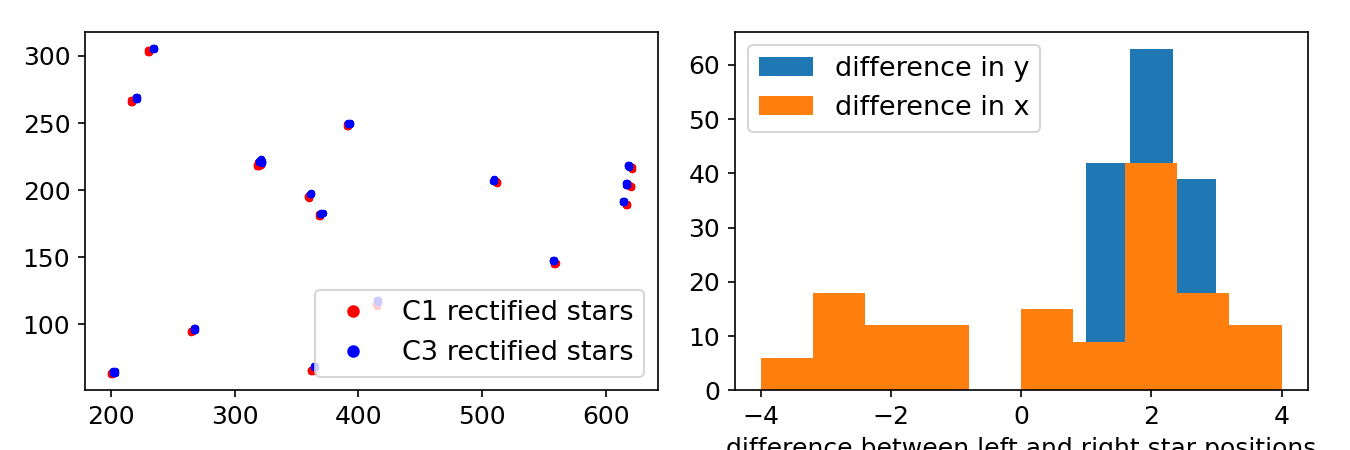

4
1.9791666666666667


In [34]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(9,3))
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['legend.markerscale'] = 2
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 12




xrco, yrco, __ = np.where(rimgR==(255,255,255))
xlco, ylco, __ = np.where(rimgL==(255,255,255))

ax1.plot(yrco, xrco, 'r.', ms=5, label='C1 rectified stars')
ax1.plot(ylco, xlco, 'b.', ms=5, label='C3 rectified stars')
ax1.legend()
plt.tight_layout()

# confusing notations here because opencv and matplotlib have different conventions for x and y order
yresiduals = []
for r in range(0, len(xlco)):
    if 0 < xlco[r]-xrco[r] < 10:
        yresiduals.append(xlco[r]-xrco[r])
        
xresiduals = []
for r in range(0, len(ylco)):
    if -30 < ylco[r]-yrco[r] < 10:
        xresiduals.append(ylco[r]-yrco[r])
    
ax2.hist(yresiduals, bins=3, label='difference in y')
ax2.hist(xresiduals, bins=10, label='difference in x')
ax2.set_xlabel('difference between left and right star positions')
ax2.legend()
print(max(xresiduals))
print(np.mean(yresiduals))

plt.savefig('rectifiedStars.png', bbox_inches='tight', dpi=1000)


## 3D projection using cameratransform

In [159]:
import cameratransform as ct
# Our origin is at camera 3 so we want all the parameters for this camera

# intrinsic camera parameters
f_mm = 3.04    # in mm
#pixel_size = 1.12e-3 # length of one side of square pixel in mm
pixel_size = 5.75e-3
sensor_size = (3.68, 2.76) # in mm
image_size = (w,h)    # in px
f_x_px = (f_mm /sensor_size[0]) * image_size[0] #focal length relative to pixel width
f_y_px = (f_mm /sensor_size[1]) * image_size[1] #focallength relative to pixel height

camera = ct.Camera(ct.RectilinearProjection(focallength_x_px = f_x_px, focallength_y_px = f_y_px, image = rimgL))
camera.setGPSpos(51.4993318750954, -0.17901837289811393, 46)
#using values calculated for camera 3 using cameratransform
camera.elevation_m = 45.331277  
camera.tilt_deg = 113.702596 
camera.heading_deg = 82.665769
camera.roll_deg = -1.204690        #110.847355 90.425038 -19.934881

In [160]:
L = np.array([[0,-1,0],      # goes from coordinates that cameratransform is using to coordinates that im3d is using
              [0,0,1],
              [-1,0,0]])

L_inv = np.linalg.inv(L)

h = 82.665769
t = 113.702596 - 90
r =-1.204690

R = np.array([[np.cos(h)*np.cos(r) - np.sin(h)*np.sin(t)*np.sin(r), 
                                    -np.sin(h)*np.cos(t), 
                                    np.cos(h)*np.cos(r) + np.sin(h)*np.sin(t)*np.sin(r)],

                [np.sin(h)*np.cos(r)-np.cos(h)*np.sin(t)*np.sin(r), 
                                    np.cos(h)*np.cos(t), 
                                    np.sin(h)*np.sin(r)-np.cos(h)*np.sin(t)*np.cos(r)],

                [-np.cos(t)*np.sin(r), np.sin(t), np.cos(t)*np.cos(r)]])


roll_rot = np.array([[np.cos(r), 0, np.sin(r)],
                    [0,          1,         0],
                    [-np.sin(r), 0, np.cos(r)]])

heading_rot = np.array([[np.cos(h), -np.sin(h), 0],
                        [np.sin(h), np.cos(h),  0],
                        [0,         0,          1]])

tilt_rot = np.array([[1,        0,         0],
                    [0, np.cos(t), -np.sin(t)],
                    [0, np.sin(t), np.cos(t)]])


def cam2world(cam, l, r):
    l_inv = np.linalg.inv(l)
    r_inv = np.linalg.inv(r)
    flip = np.matmul(l_inv, cam)
    return np.matmul(r_inv, flip)


def cam2worldv2(cam, head=heading_rot, tilt=tilt_rot, roll=roll_rot, l=L):
    head_inv = np.linalg.inv(head)
    tilt_inv = np.linalg.inv(tilt)
    roll_inv = np.linalg.inv(roll)
    l_inv = np.linalg.inv(l)
    rot = np.matmul(head_inv, tilt_inv, roll_inv)
    flip = np.matmul(l_inv, cam)
    return np.matmul(rot, cam)


def world2gps(x, y, origin=(51.4993318750954, -0.17901837289811393)):
    dist = np.sqrt(x**2 + y**2)
    angle = np.arctan(y/x)
    return inverse_haversine(origin, dist, angle, unit=Unit.METERS)



In [165]:
depth_x = []
depth_y = []
depth_val = []
space_coords = []
world_coords = []
heights = []
for j in range (0,480):
    for i in range (0,640):
        if 0 < depths[j,i] < 50000:
            if stereo_z[j,i] != 0:
                depth_val.append(depths[j,i])
                depth_x.append(i)
                depth_y.append(j)
                elev = np.arccos(stereo_z[j,i]/depths[j,i])
                tilt = (np.pi/180) * (camera.tilt_deg - 90)
                #flip = np.matmul(L_inv, np.array([stereo_x[j,i], stereo_y[j,i], stereo_z[j,i]]))
                world_coord = camera.gpsFromSpace(np.array([stereo_z[j,i], -stereo_x[j,i], stereo_y[j,i]]))
                #world_coord = cam2worldv2(np.array([stereo_x[j,i], stereo_y[j,i], stereo_z[j,i]]))
                #gps = world2gps(world_coord[0], world_coord[1])
                height = stereo_z[j,i] * np.tan(tilt + elev) + 46
                heights.append(height)
                world_coords.append(world_coord)    
                space_coord = camera.spaceFromImage([i,j], Z=depths[j,i])
                space_coords.append(np.array(space_coord))
        
depth_x = np.array(depth_x)
depth_y = np.array(depth_y)  
depth_val = np.array(depth_val)
space_coords = np.array(space_coords)
world_coords = np.array(world_coords)
heights = np.array(heights)


print(world_coords.shape)

(1558, 3)


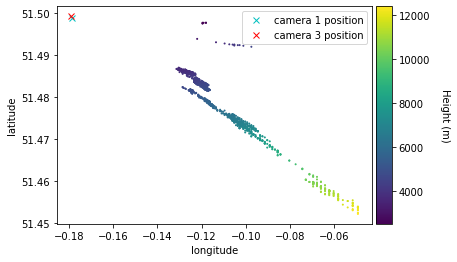

In [166]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
world = ax.scatter(world_coords[:,1], world_coords[:,0], 1, heights)
ax.plot(-0.1788492157810761, 51.49880908055068, 'cx', label='camera 1 position')
ax.plot(-0.17901837289811393, 51.4993318750954, 'rx', label='camera 3 position')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(world, cax=cax, orientation='vertical')
cbar.set_label('Height (m)', rotation=270, labelpad=20)
ax.legend()
#plt.savefig(f'{dtime}_{hour}_frame_{frame_no+1}_world_Ronnie.png', bbox_inches='tight')


<IPython.core.display.Javascript object>


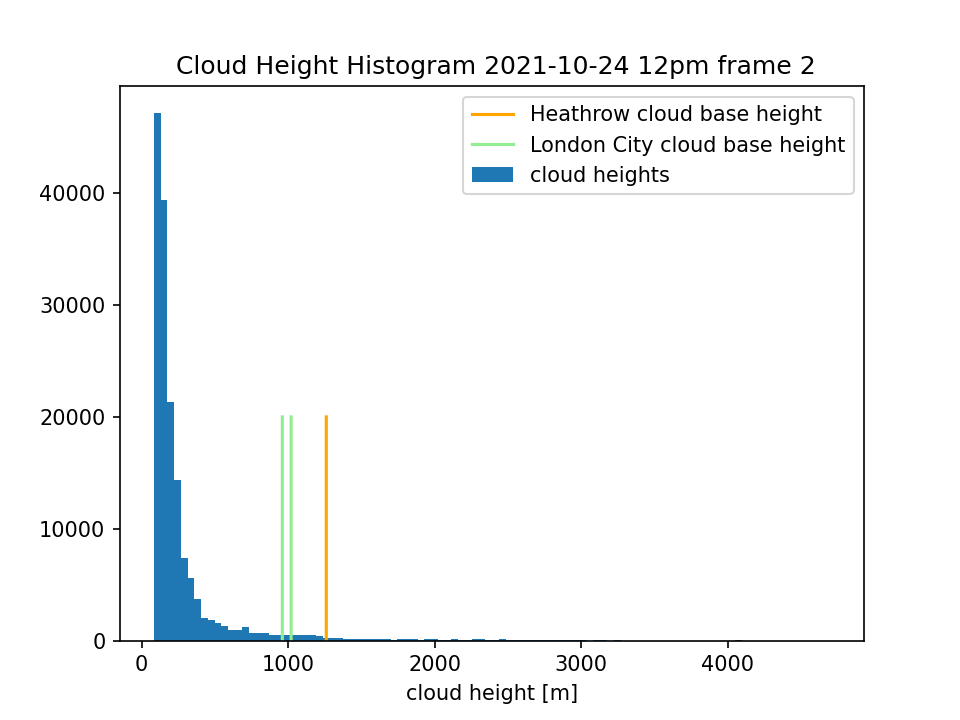

In [110]:
fig, ax = plt.subplots(1,1)
ax.hist(heights, bins=100, label='cloud heights')
y = np.arange(0,20000,1)
x = np.ones(20000)
ax.plot(1260*x, y, color='orange', label='Heathrow cloud base height')
ax.plot(960*x, y, color='lightgreen', label='London City cloud base height')
ax.plot(1020*x, y, color='lightgreen')
ax.set_xlabel('cloud height [m]')
ax.set_title(f' Cloud Height Histogram {dtime} {hour}pm frame {frame_no+1}')
ax.legend()
#plt.savefig(f'{dtime}_{hour}_frame_{frame_no+1}_heights_histogram.png', bbox_inches = 'tight')


<IPython.core.display.Javascript object>


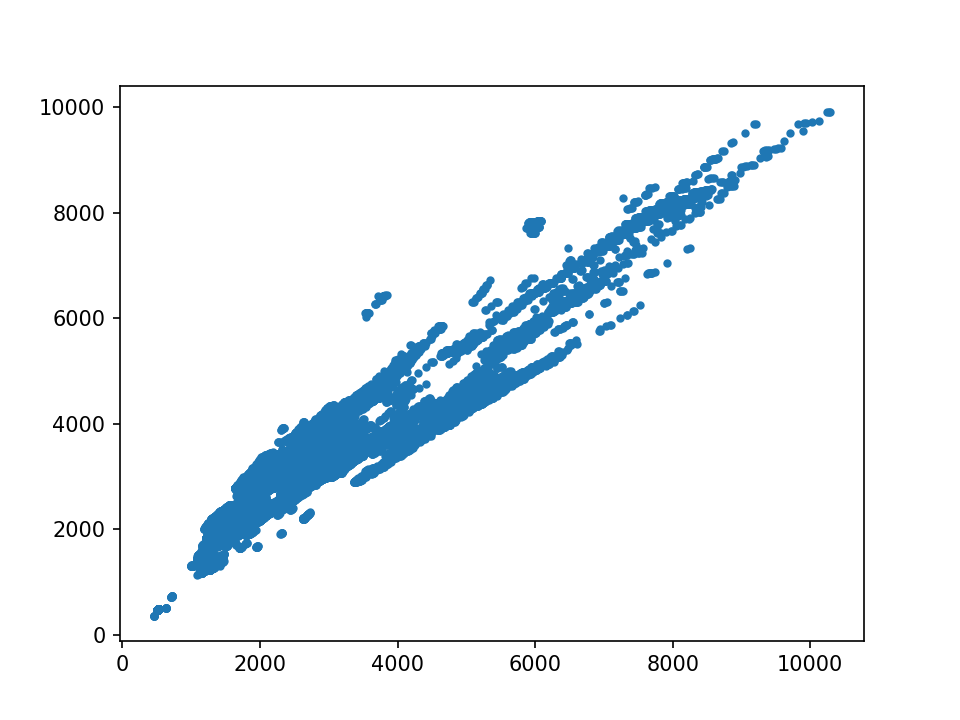

In [104]:
fig, ax = plt.subplots(1,1)
ax.plot(heights, depth_val, '.')

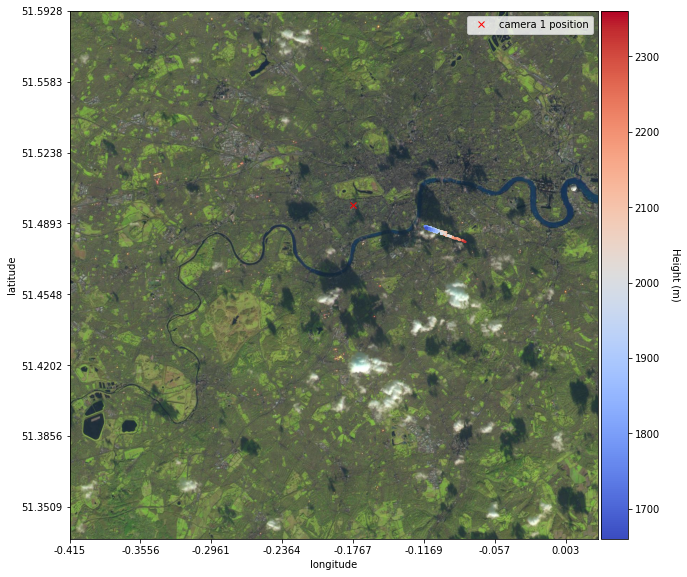

In [579]:
# from https://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file

from osgeo import gdal, osr
from matplotlib.ticker import StrMethodFormatter
import matplotlib.pyplot as plt
import numpy as np

ds = gdal.Open("C:/Users/kathe/OneDrive - Imperial College London/MSci Project/sentinel2A_20210928.tif")
old_cs= osr.SpatialReference()
old_cs.ImportFromWkt(ds.GetProjectionRef())

# create the new coordinate system
wgs84_wkt = """
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]"""
new_cs = osr.SpatialReference()#
new_cs .ImportFromWkt(wgs84_wkt)

# create a transform object to convert between coordinate systems
transform = osr.CoordinateTransformation(old_cs,new_cs)

width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 

def landsat_coords(i, j):
    x = gt[0] + i*gt[1] + j*gt[2]
    #y = gt[3] + (width-i)*gt[4] + (height-j)*gt[5]
    y = gt[3] + i*gt[4] + j*gt[5]
    return transform.TransformPoint(x, y)

# lat = []
# long = []
# #get the coordinates in lat long
# for i in range(int(minx),int(maxx), 20):
#     for j in range(int(miny), int(maxy), 20):
#         lat.append(transform.TransformPoint(i,j)[0])
#         long.append(transform.TransformPoint(i,j)[1])
# ##latlong = transform.TransformPoint(landsat_coords(0,0)[0], landsat_coords(0,0)[1])



px = np.arange(0,5490,1)
py = np.arange(0,5490,1)

oldx = np.array([4000,4200,4400,4600,4800,5000,5200,5400])
oldy = np.array([5400,5200,5000,4800,4600,4400,4200,4000])

gps = list(map(landsat_coords, px, py))
gps = np.array(gps)

new = list(map(landsat_coords, oldx, oldy))
new = np.array(new)
lat = new[:,0]
long = new[:,1]


im = plt.imread("C:/Users/kathe/OneDrive - Imperial College London/MSci Project/sentinel2B_20220131.tif")
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_xlim(4000,5490)
ax.set_ylim(5490,4000)
ax.imshow(im)
ax.set_xticks(oldx, np.round(long, 4))
ax.set_yticks(oldy, np.round(lat, 4))
world = ax.scatter(
    coord_to_pixel_x(gps_dists_auto[:,1]), 
    coord_to_pixel_y(gps_dists_auto[:,0]), 
    2, 
    gps_dists_auto[:,2], cmap='coolwarm')
# ax.plot(-0.1788492157810761, 51.49880908055068, 'cx', label='camera 1 position')
# ax.plot(-0.17901837289811393, 51.4993318750954, 'rx', label='camera 3 position')

c1x = coord_to_pixel_x(-0.1788492157810761)
c1y = coord_to_pixel_y(51.49880908055068)
ax.plot(c1x, c1y, 'rx', label='camera 1 position')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(world, cax=cax, orientation='vertical')
cbar.set_label('Height (m)', rotation=270, labelpad=20)
ax.legend()
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.savefig(f'2021-09-28_11_satellite_frame_{frame_no+1}.png', bbox_inches='tight')


In [42]:
world_coords[:,1].shape

(23751,)

In [49]:
def coord_to_pixel_x(coord, min_coord=-1.563879374885302, max_coord=0.02, points=5490):
    return (coord - min_coord) / (max_coord - min_coord) * points
def coord_to_pixel_y(coord, min_coord=51.324523354307196, max_coord=52.34135509678961, points=5490):
    return points - (coord - min_coord) / (max_coord - min_coord) * points

  Using cached cameratransform-1.2-py3-none-any.whl (48 kB)
  Using cached tqdm-4.62.3-py2.py3-none-any.whl (76 kB)
  Using cached pytz-2021.3-py2.py3-none-any.whl (503 kB)


In [72]:
!gdalinfo "C:/Users/kathe/OneDrive - Imperial College London/MSci Project/sentinel2A_20210928.tif" 

Driver: GTiff/GeoTIFF
Files: C:/Users/kathe/OneDrive - Imperial College London/MSci Project/sentinel2A_20210928.tif
Size is 5490, 5490
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 30N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 30N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-3,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
      

In [209]:
!pip install haversine

  Using cached haversine-2.5.1-py2.py3-none-any.whl (6.1 kB)
